In [1]:
%matplotlib inline

import pennylane as qml
from pennylane import numpy as np
import jax
from jax import numpy as jnp
import optax
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from concrete_CCQC_digits import concrete_CCQC
import matplotlib.pyplot as plt
import warnings
from skimage.transform import resize

warnings.filterwarnings("ignore")
np.random.seed(42)


def replace_values(arr, old_value, new_value):
    return np.where(arr == old_value, new_value, arr)

def resize_image(images, new_size=(4, 4)):
    """Resize a 2D image to a new size."""
    return np.array([resize(img, new_size, anti_aliasing=True) for img in images])

def square_loss(labels, predictions):
    return np.mean((labels - qml.math.stack(predictions)) ** 2)


def accuracy(labels, predictions):
    acc = sum([np.sign(l) == np.sign(p) for l, p in zip(labels, predictions)])
    acc = acc / len(labels)
    return acc


def cost(params, X, Y):
    predictions = []
    for x in X:
        vqc = concrete_CCQC(data=x, weights=params["weights"], bias=params["bias"])
        predictions.append(vqc())
    return square_loss(Y, predictions)


def acc(params, X, Y):
    predictions = []
    for x in X:
        vqc = concrete_CCQC(data=x, weights=params["weights"], bias=params["bias"])
        predictions.append(vqc())
    # predictions = [variational_classifier(params["weights"], params["bias"], x) for x in X]
    return accuracy(Y, predictions)

@jax.jit
def update_step_jit(i, args):
    params, opt_state, data, targets, batch_no = args
    _data = data[batch_no % num_batch]
    _targets = targets[batch_no % num_batch]
    _, grads = jax.value_and_grad(cost)(params, _data, _targets)
    updates, opt_state = opt.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return (params, opt_state, data, targets, batch_no + 1)


@jax.jit
def optimization_jit(params, data, targets):
    opt_state = opt.init(params)
    args = (params, opt_state, data, targets, 0)
    (params, opt_state, _, _, _) = jax.lax.fori_loop(0, 200, update_step_jit, args)
    return params



In [2]:
num_qubits = 4 # 2,3,4 better choices


def get_data(class_0, class_1, batch_size=7):
    # Load the digits dataset with features (X_digits) and labels (y_digits)
    X_digits, y_digits = load_digits(return_X_y=True)
    
    # Create a boolean mask to filter out only the samples where the label is 2 or 6
    filter_mask = np.isin(y_digits, [class_0, class_1])
    
    # Apply the filter mask to the features and labels to keep only the selected digits
    X_digits = X_digits[filter_mask]
    y_digits = y_digits[filter_mask]    
    
    # Split the filtered dataset into training and testing sets with 10% of data reserved for testing
    X_train, X_test, y_train, y_test = train_test_split(
        X_digits, y_digits, test_size=0.1, random_state=42
    )
    
    # Makes the total number of samples divisible by 7
    if X_train.shape[0] % 7 != 0:
        X_train = X_train[: -(X_train.shape[0] % batch_size)]
        y_train = y_train[: -(y_train.shape[0] % batch_size)]

    
    # Normalize the pixel values in the training and testing data
    # Convert each image from a 1D array to an 8x8 2D array, normalize pixel values, and scale them
    X_train = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_train])
    X_test = np.array([thing.reshape([8, 8]) / 16 * 2 * np.pi for thing in X_test])
    
    # Adjust the labels to be centered around 0 and scaled to be in the range -1 to 1
    # The original labels (2 and 6) are mapped to -1 and 1 respectively
    y_train = replace_values(y_train, class_0, -1)
    y_train = replace_values(y_train, class_1, 1)
    y_test = replace_values(y_test, class_0, -1)
    y_test = replace_values(y_test, class_1, 1)
    
    # Resize the images to 4x4
    X_train = resize_image(X_train, new_size=(num_qubits, num_qubits))
    X_test = resize_image(X_test, new_size=(num_qubits, num_qubits))
    
    return X_train, y_train, X_test, y_test
    # Reshape the training and testing data to have a batch size of 7



# TO PLOT NUMBERS:
# fig, axes = plt.subplots(nrows=2, ncols=3, layout="constrained")
# for i in range(2):
#     for j in range(3):
#       axes[i][j].matshow(X_train[2*(2*j+i)])
#       axes[i][j].axis('off')
# 
# fig.subplots_adjust(hspace=0.0)
# fig.tight_layout()
# plt.show()

In [3]:
batch_size = 7


for class_0, class_1 in [(0,1), (2,3), (2, 6), (2,8), (3, 7), (8, 1)]:
    weights = 0.01 * np.random.randn(num_qubits*2)
    bias = jnp.array(0.0)
    params = {"weights": weights, "bias": bias}
    opt = optax.adam(0.05)
    print("Number considered: ", class_0, class_1)    
    X_train, y_train, X_test, y_test = get_data(class_0,class_1)
    num_batch = X_train.shape[0] // batch_size
    opt_state = opt.init(params)
    X_batched = X_train.reshape([-1, batch_size, num_qubits, num_qubits])
    y_batched = y_train.reshape([-1, batch_size])
    params = optimization_jit(params, X_batched, y_batched)
    var_train_acc = acc(params, X_train, y_train)
    var_test_acc = acc(params, X_test, y_test)
    print("Training accuracy: ", var_train_acc)
    print("Testing accuracy: ", var_test_acc)
    print("----------")
    # save the parameters to a file
    np.savez(f"variational_params_{num_qubits}_{class_0,class_1}.npz", weights=params["weights"], bias=params["bias"])

Number considered:  0 1
Training accuracy:  0.9130434782608695
Testing accuracy:  0.9444444444444444
----------
Number considered:  2 3
Training accuracy:  0.6832298136645962
Testing accuracy:  0.6111111111111112
----------
Number considered:  2 6
Training accuracy:  0.8354037267080745
Testing accuracy:  0.7777777777777778
----------
Number considered:  2 8
Training accuracy:  0.7904761904761904
Testing accuracy:  0.6944444444444444
----------
Number considered:  3 7
Training accuracy:  0.6490683229813664
Testing accuracy:  0.5945945945945946
----------
Number considered:  8 1
Training accuracy:  0.6761904761904762
Testing accuracy:  0.6388888888888888
----------


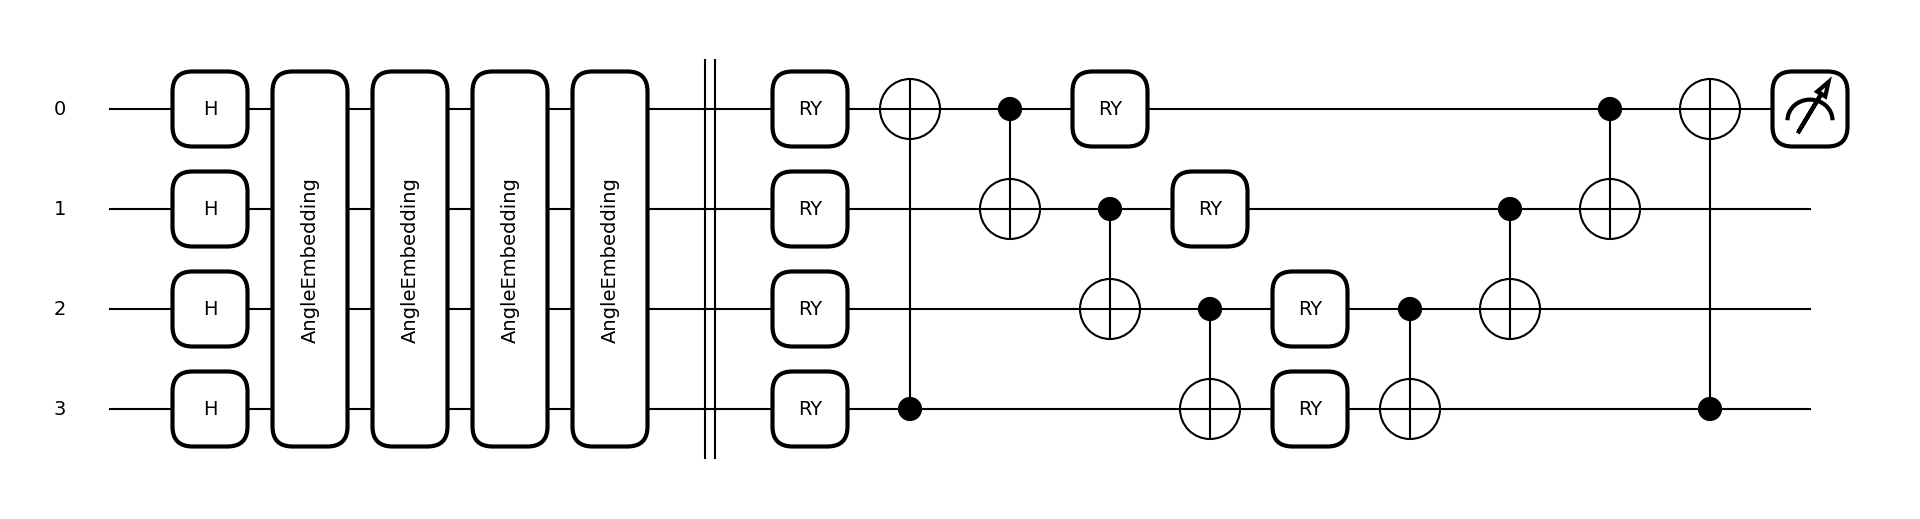

In [4]:
qml.draw_mpl(concrete_CCQC(data=X_test[0], weights=params["weights"], bias=params["bias"]).circuit)()
plt.savefig("digits_CCQC.pdf", dpi=300, bbox_inches='tight')
plt.show()

#### Results training with different resizing

4,4: 

Train:    0.8354037267080745

Testing:  0.7777777777777778

----------
3, 3:

Training accuracy:  0.8850931677018633

Testing accuracy:  0.8333333333333334

----------
2, 2:

Training accuracy:  0.8105590062111802

Testing accuracy:  0.8888888888888888